In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras import optimizers

In [2]:
def preparedata(file):
    cloud_cover = pd.read_csv(file, skipinitialspace = True)
    cloud_cover['Date'] = cloud_cover[['Year', 'Month', 'Day']].apply(lambda x: "{0}-{1}-{2}".format(str(x[0]).zfill(2), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1) 
    cloud_cover['Time'] = cloud_cover[['Hour', 'Minute']].apply(lambda x: "{}:{}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
    cloud_cover.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1, inplace=True)  
    cloud_cover = cloud_cover.rename(columns={"CloudCover":"cloud_cover"})
    cloud_cover = cloud_cover.groupby(['Date', 'Time']).agg(cloud_cover=('cloud_cover','mean')).reset_index()
    cloud_cover['DateTime'] = cloud_cover[['Date', 'Time']].apply(lambda x: "{} {}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
    cloud_cover.drop(["Date", "Time"], axis=1, inplace=True)        
    cloud_cover['DateTime'] = pd.to_datetime(cloud_cover['DateTime'], format="%Y-%m-%d %H:%M")
    cloud_cover.dropna(inplace=True)
    return cloud_cover

In [3]:
cloud_cover = preparedata('../succeed-prophet/Bangkhuntean_CloudCover_2021-16Nov-16Dec.csv')
cloud_cover

cloud_cover            DateTime
0         0.990000 2021-11-16 11:15:00
1         0.989000 2021-11-16 11:16:00
2         0.987667 2021-11-16 11:17:00
3         0.987000 2021-11-16 11:18:00
4         0.987000 2021-11-16 11:19:00
...            ...                 ...
15056     0.168000 2021-12-16 13:58:00
15057     0.169000 2021-12-16 13:59:00
15058     0.147000 2021-12-16 14:00:00
15059     0.145000 2021-12-16 14:01:00
15060     0.144000 2021-12-16 14:02:00

[15061 rows x 2 columns]

In [4]:
def lags_train_test(data, lags):
	X, y = [], []
	for i in range(lags, len(data)):
		X.append(data[i-lags:i])
		y.append(data[i])
	return np.array(X), np.array(y)

In [5]:
def Xtrain_ytrain(train,test,lags):
    #scale train
    sc = MinMaxScaler()
    sc.fit(train)
    train_set_scale = sc.transform(train)
    # train
    X_train, y_train = lags_train_test(train_set_scale, lags)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    print("X_train Shape :", X_train.shape)
    print("y_train Shape :", y_train.shape)

    #scale test
    dataset_total = pd.concat((train['cloud_cover'], test['cloud_cover']), axis=0)
    inputs = dataset_total[len(dataset_total) - len(test) - lags:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    # test
    X_test, y_test = lags_train_test(inputs, lags)
    print("X_test Shape : ", X_test.shape)
    print("y_test Shape : ", y_test.shape)
    return X_train, y_train, X_test, y_test, sc

In [6]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [7]:
def plot_test(train,pred):
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(mode = 'lines', x = train['DateTime'], y = train['cloud_cover'], name = 'Train'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['cloud_cover'], name = 'Actual'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['LSTM'], name = 'Predict'))
    fig2.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
    )


    fig2.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=2,
                        label="2.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=3,
                        label="3.zoom",
                        step="day",
                        stepmode="backward"),              

                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig2.show()

# n_splits = 10

## Run in loop and lags 5

### Optimizer adam batch size 32 units 100 second layer 100 epochs 10 

In [52]:
cv = TimeSeriesSplit(n_splits=10)
mse = []
for train,test in cv.split(cloud_cover):
    print('TRAIN:', train.shape, 'TEST:', test.shape) 
    train, test = cloud_cover.iloc[train, :], cloud_cover.iloc[test, :]
    train = train.set_index('DateTime')
    test = test.set_index('DateTime')
    
    # X_train, y_train, X_test and y_test
    X_train, y_train, X_test, y_test, sc = Xtrain_ytrain(train,test,5)

    # model
    regressor = Sequential()
    regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(LSTM(units = 100))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    hist = regressor.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10, batch_size = 32) 
    predict_scaled = regressor.predict(X_test)
    predict = sc.inverse_transform(predict_scaled)
    test['LSTM'] = predict
    lstm_mse_error = mean_squared_error(test['cloud_cover'], test['LSTM'], squared=True)
    print('lstm mse error lags 5: ', lstm_mse_error)
    print('\n')
    mse.append(lstm_mse_error)

TRAIN: (1371,) TEST: (1369,)
X_train Shape : (1366, 5, 1)
y_train Shape : (1366, 1)
X_test Shape :  (1369, 5, 1)
y_test Shape :  (1369, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
43/43 [==============================] - 9s 56ms/step - loss: 0.0656 - val_loss: 0.0070
Epoch 2/10
43/43 [==============================] - 1s 20ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 3/10
43/43 [==============================] - 1s 19ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 4/10
43/43 [==============================] - 1s 17ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 5/10
43/43 [==============================] - 1s 17ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 6/10
43/43 [==============================] - 1s 18ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 7/10
43/43 [==============================] - 1s 16ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 8/10
43/43 [==============================] - 1s 17ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 9/10
43/43 [==============================] - 1s 17ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 10/10
43/43 [==============================] - 1s 10ms/step
lstm mse error lags 5:  0.00299495401379906

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
86/86 [==============================] - 8s 37ms/step - loss: 0.0318 - val_loss: 0.0041
Epoch 2/10
86/86 [==============================] - 1s 16ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 3/10
86/86 [==============================] - 1s 14ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 4/10
86/86 [==============================] - 1s 16ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 5/10
86/86 [==============================] - 1s 14ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 6/10
86/86 [==============================] - 1s 14ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 7/10
86/86 [==============================] - 1s 15ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 8/10
86/86 [==============================] - 1s 17ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 9/10
86/86 [==============================] - 1s 15ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 10/10
43/43 [==============================] - 1s 7ms/step
lstm mse error lags 5:  0.00290284475363618


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
129/129 [==============================] - 11s 22ms/step - loss: 0.0266 - val_loss: 0.0025
Epoch 2/10
129/129 [==============================] - 2s 15ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 3/10
129/129 [==============================] - 2s 14ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 4/10
129/129 [==============================] - 2s 13ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 5/10
129/129 [==============================] - 2s 13ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 6/10
129/129 [==============================] - 2s 15ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 7/10
129/129 [==============================] - 2s 14ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 8/10
129/129 [==============================] - 2s 16ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 9/10
129/129 [==============================] - 2s 14ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 10/10
43/43 [==============================] - 1s 5ms/step
lstm mse error lags 5:  0

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
172/172 [==============================] - 8s 19ms/step - loss: 0.0151 - val_loss: 0.0023
Epoch 2/10
172/172 [==============================] - 2s 13ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 3/10
172/172 [==============================] - 2s 13ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 4/10
172/172 [==============================] - 2s 13ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 5/10
172/172 [==============================] - 2s 14ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 6/10
172/172 [==============================] - 2s 14ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 7/10
172/172 [==============================] - 3s 15ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 8/10
172/172 [==============================] - 2s 14ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 9/10
172/172 [==============================] - 2s 14ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 10/10
43/43 [==============================] - 1s 7ms/step
lstm mse error lags 5:  0.

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
214/214 [==============================] - 8s 18ms/step - loss: 0.0120 - val_loss: 7.0466e-04
Epoch 2/10
214/214 [==============================] - 3s 12ms/step - loss: 0.0030 - val_loss: 5.9050e-04
Epoch 3/10
214/214 [==============================] - 3s 12ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 4/10
214/214 [==============================] - 3s 12ms/step - loss: 0.0026 - val_loss: 4.9926e-04
Epoch 5/10
214/214 [==============================] - 3s 13ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 6/10
214/214 [==============================] - 3s 12ms/step - loss: 0.0020 - val_loss: 5.4945e-04
Epoch 7/10
214/214 [==============================] - 3s 12ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 8/10
214/214 [==============================] - 3s 12ms/step - loss: 0.0016 - val_loss: 4.3454e-04
Epoch 9/10
214/214 [==============================] - 3s 14ms/step - loss: 0.0015 - val_loss: 7.6840e-04
Epoch 10/10
43/43 [==============================] - 1s 5ms/step
ls

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
257/257 [==============================] - 9s 16ms/step - loss: 0.0130 - val_loss: 0.0017
Epoch 2/10
257/257 [==============================] - 3s 12ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 3/10
257/257 [==============================] - 3s 13ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 4/10
257/257 [==============================] - 3s 12ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 5/10
257/257 [==============================] - 3s 13ms/step - loss: 0.0020 - val_loss: 9.7822e-04
Epoch 6/10
257/257 [==============================] - 3s 12ms/step - loss: 0.0017 - val_loss: 8.5015e-04
Epoch 7/10
257/257 [==============================] - 3s 12ms/step - loss: 0.0015 - val_loss: 8.4549e-04
Epoch 8/10
257/257 [==============================] - 3s 13ms/step - loss: 0.0014 - val_loss: 7.8486e-04
Epoch 9/10
257/257 [==============================] - 3s 12ms/step - loss: 0.0012 - val_loss: 5.4361e-04
Epoch 10/10
43/43 [==============================] - 1s 6ms/step
lstm m

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
300/300 [==============================] - 9s 15ms/step - loss: 0.0097 - val_loss: 0.0033
Epoch 2/10
300/300 [==============================] - 3s 12ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 3/10
300/300 [==============================] - 4s 12ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 4/10
300/300 [==============================] - 4s 12ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 5/10
300/300 [==============================] - 4s 12ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 6/10
300/300 [==============================] - 4s 13ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/10
300/300 [==============================] - 4s 12ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 8/10
300/300 [==============================] - 4s 12ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 9/10
300/300 [==============================] - 4s 12ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 10/10
43/43 [==============================] - 1s 5ms/step
lstm mse error lags 5:  0.

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
343/343 [==============================] - 9s 15ms/step - loss: 0.0092 - val_loss: 0.0030
Epoch 2/10
343/343 [==============================] - 4s 12ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 3/10
343/343 [==============================] - 4s 11ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 4/10
343/343 [==============================] - 4s 12ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 5/10
343/343 [==============================] - 4s 13ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 6/10
343/343 [==============================] - 4s 12ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 7/10
343/343 [==============================] - 4s 12ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 8/10
343/343 [==============================] - 4s 12ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 9/10
343/343 [==============================] - 4s 12ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/10
43/43 [==============================] - 1s 5ms/step
lstm mse error lags 5:  0.

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
385/385 [==============================] - 11s 15ms/step - loss: 0.0090 - val_loss: 0.0043
Epoch 2/10
385/385 [==============================] - 5s 12ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 3/10
385/385 [==============================] - 5s 12ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 4/10
385/385 [==============================] - 4s 12ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 5/10
385/385 [==============================] - 5s 12ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 6/10
385/385 [==============================] - 4s 12ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 7/10
385/385 [==============================] - 5s 12ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 8/10
385/385 [==============================] - 4s 12ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 9/10
385/385 [==============================] - 5s 12ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 10/10
43/43 [==============================] - 1s 7ms/step
lstm mse error lags 5:  0

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
428/428 [==============================] - 12s 15ms/step - loss: 0.0085 - val_loss: 0.0029
Epoch 2/10
428/428 [==============================] - 5s 12ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 3/10
428/428 [==============================] - 5s 12ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 4/10
428/428 [==============================] - 5s 12ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/10
428/428 [==============================] - 5s 11ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/10
428/428 [==============================] - 5s 12ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/10
428/428 [==============================] - 5s 12ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/10
428/428 [==============================] - 6s 13ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/10
428/428 [==============================] - 5s 12ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/10
43/43 [==============================] - 1s 4ms/step
lstm mse error lags 5:  0

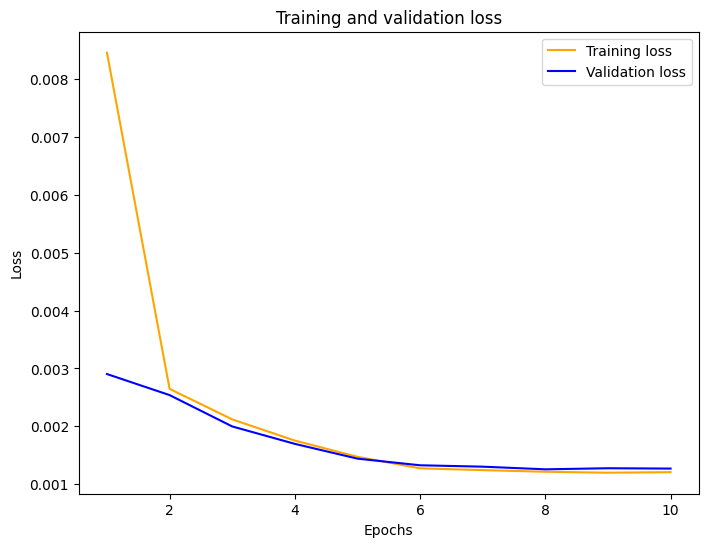

In [53]:
plot_curve(hist)

In [54]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [55]:
test

DateTime  cloud_cover      LSTM
0    2021-12-13 16:28:00        0.124  0.128471
1    2021-12-13 16:29:00        0.119  0.126588
2    2021-12-13 16:30:00        0.103  0.122203
3    2021-12-13 16:31:00        0.104  0.108005
4    2021-12-13 16:32:00        0.101  0.106531
...                  ...          ...       ...
1364 2021-12-16 13:58:00        0.168  0.170789
1365 2021-12-16 13:59:00        0.169  0.170575
1366 2021-12-16 14:00:00        0.147  0.171407
1367 2021-12-16 14:01:00        0.145  0.152725
1368 2021-12-16 14:02:00        0.144  0.148323

[1369 rows x 3 columns]

In [56]:
print('lstm mse error lag 5: ', lstm_mse_error)

lstm mse error lag 5:  0.0012643959648525106


In [57]:
plot_test(train,test)

In [58]:
lag5 = np.mean(mse)
lag5

0.001640478208215394

---

## Run in loop and lags 10

### Optimizer adam first layer 50 batch size 32 learning rate 0.05 epochs 10

In [16]:
cv1 = TimeSeriesSplit(n_splits=10)
mse1 = []
for train1,test1 in cv1.split(cloud_cover):
    print('TRAIN:', train1.shape, 'TEST:', test1.shape) 
    train1, test1 = cloud_cover.iloc[train1, :], cloud_cover.iloc[test1, :]
    train1 = train1.set_index('DateTime')
    test1 = test1.set_index('DateTime')
    
    # X_train1, y_train1, X_test1 and y_test1
    X_train1, y_train1, X_test1, y_test1, sc1 = Xtrain_ytrain(train1,test1,10)

    # model
    regressor1 = Sequential()
    regressor1.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train1.shape[1], 1)))
    regressor1.add(Dense(units = 1))
    opt = optimizers.Adam(learning_rate=0.05)
    regressor1.compile(optimizer = opt, loss = 'mean_squared_error')
    hist1 = regressor1.fit(X_train1, y_train1, validation_data=(X_test1, y_test1), epochs = 10, batch_size = 32) 
    predict_scaled1 = regressor1.predict(X_test1)
    predict1 = sc1.inverse_transform(predict_scaled1)
    test1['LSTM'] = predict1
    lstm_mse_error1 = mean_squared_error(test1['cloud_cover'], test1['LSTM'], squared=True)
    print('lstm mse error lags 10 : ', lstm_mse_error1)
    print('\n')
    mse1.append(lstm_mse_error1)

TRAIN: (1371,) TEST: (1369,)
X_train Shape : (1361, 10, 1)
y_train Shape : (1361, 1)
X_test Shape :  (1369, 10, 1)
y_test Shape :  (1369, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
43/43 [==============================] - 4s 24ms/step - loss: 0.2104 - val_loss: 0.0123
Epoch 2/10
43/43 [==============================] - 0s 10ms/step - loss: 0.0095 - val_loss: 0.0083
Epoch 3/10
43/43 [==============================] - 0s 11ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 4/10
43/43 [==============================] - 0s 10ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 5/10
43/43 [==============================] - 0s 10ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 6/10
43/43 [==============================] - 0s 10ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 7/10
43/43 [==============================] - 0s 9ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 8/10
43/43 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 9/10
43/43 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 10/10
43/43 [==============================] - 1s 3ms/step
lstm mse error lags 10 :  0.00133579046745513

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
86/86 [==============================] - 4s 14ms/step - loss: 0.0363 - val_loss: 0.0028
Epoch 2/10
86/86 [==============================] - 1s 8ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 3/10
86/86 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 4/10
86/86 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 5/10
86/86 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/10
86/86 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/10
86/86 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 8/10
86/86 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/10
86/86 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 10/10
43/43 [==============================] - 1s 3ms/step
lstm mse error lags 10 :  0.0013944009064409285


TR

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
129/129 [==============================] - 4s 12ms/step - loss: 0.0470 - val_loss: 0.0034
Epoch 2/10
129/129 [==============================] - 1s 7ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 3/10
129/129 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/10
129/129 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/10
129/129 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 6/10
129/129 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/10
129/129 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/10
129/129 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 9/10
129/129 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/10
43/43 [==============================] - 1s 3ms/step
lstm mse error lags 10 :  0.001727

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
171/171 [==============================] - 4s 10ms/step - loss: 0.0355 - val_loss: 0.0017
Epoch 2/10
171/171 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 3/10
171/171 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 4/10
171/171 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 5/10
171/171 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 6/10
171/171 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/10
171/171 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/10
171/171 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/10
171/171 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/10
43/43 [==============================] - 1s 3ms/step
lstm mse error lags 10 :  0.001195

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
214/214 [==============================] - 5s 10ms/step - loss: 0.0308 - val_loss: 0.0017
Epoch 2/10
214/214 [==============================] - 2s 7ms/step - loss: 0.0019 - val_loss: 1.8858e-04
Epoch 3/10
214/214 [==============================] - 2s 10ms/step - loss: 0.0016 - val_loss: 2.4033e-04
Epoch 4/10
214/214 [==============================] - 2s 10ms/step - loss: 0.0013 - val_loss: 1.4156e-04
Epoch 5/10
214/214 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 6.5388e-04
Epoch 6/10
214/214 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 1.8605e-04
Epoch 7/10
214/214 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/10
214/214 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 1.5782e-04
Epoch 9/10
214/214 [==============================] - 2s 7ms/step - loss: 0.0012 - val_loss: 2.6825e-04
Epoch 10/10
43/43 [==============================] - 1s 3ms/step
lstm

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
257/257 [==============================] - 5s 9ms/step - loss: 0.0408 - val_loss: 0.0016
Epoch 2/10
257/257 [==============================] - 2s 7ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 3/10
257/257 [==============================] - 2s 7ms/step - loss: 0.0013 - val_loss: 8.6520e-04
Epoch 4/10
257/257 [==============================] - 2s 7ms/step - loss: 0.0012 - val_loss: 6.5957e-04
Epoch 5/10
257/257 [==============================] - 2s 7ms/step - loss: 0.0012 - val_loss: 5.2718e-04
Epoch 6/10
257/257 [==============================] - 2s 7ms/step - loss: 0.0012 - val_loss: 5.5522e-04
Epoch 7/10
257/257 [==============================] - 2s 7ms/step - loss: 0.0011 - val_loss: 6.5331e-04
Epoch 8/10
257/257 [==============================] - 2s 7ms/step - loss: 0.0011 - val_loss: 5.9764e-04
Epoch 9/10
257/257 [==============================] - 2s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/10
43/43 [==============================] - 1s 4ms/step
lstm mse er

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
300/300 [==============================] - 5s 9ms/step - loss: 0.0123 - val_loss: 0.0017
Epoch 2/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3/10
300/300 [==============================] - 2s 6ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 4/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 6/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 7/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 8/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 9/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 10/10
43/43 [==============================] - 1s 3ms/step
lstm mse error lags 10 :  0.0016426

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
342/342 [==============================] - 5s 7ms/step - loss: 0.0172 - val_loss: 0.0022
Epoch 2/10
342/342 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 3/10
342/342 [==============================] - 2s 6ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 4/10
342/342 [==============================] - 2s 6ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 5/10
342/342 [==============================] - 2s 5ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 6/10
342/342 [==============================] - 2s 6ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/10
342/342 [==============================] - 2s 6ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 8/10
342/342 [==============================] - 2s 6ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/10
342/342 [==============================] - 2s 6ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 10/10
43/43 [==============================] - 1s 3ms/step
lstm mse error lags 10 :  0.0021665

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
385/385 [==============================] - 6s 8ms/step - loss: 0.0289 - val_loss: 0.0033
Epoch 2/10
385/385 [==============================] - 3s 7ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 3/10
385/385 [==============================] - 3s 7ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 4/10
385/385 [==============================] - 3s 7ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 5/10
385/385 [==============================] - 3s 7ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/10
385/385 [==============================] - 3s 7ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 7/10
385/385 [==============================] - 3s 7ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 8/10
385/385 [==============================] - 3s 7ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 9/10
385/385 [==============================] - 3s 7ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/10
43/43 [==============================] - 1s 3ms/step
lstm mse error lags 10 :  0.0050507

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
428/428 [==============================] - 7s 8ms/step - loss: 0.0275 - val_loss: 0.0018
Epoch 2/10
428/428 [==============================] - 3s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 3/10
428/428 [==============================] - 3s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/10
428/428 [==============================] - 3s 7ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/10
428/428 [==============================] - 3s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/10
428/428 [==============================] - 3s 7ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 7/10
428/428 [==============================] - 3s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/10
428/428 [==============================] - 3s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/10
428/428 [==============================] - 3s 7ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 10/10
43/43 [==============================] - 1s 3ms/step
lstm mse error lags 10 :  0.0012559

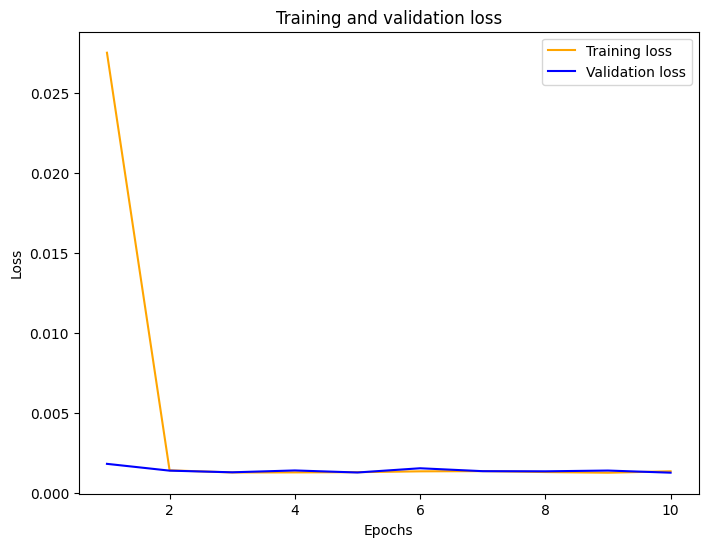

In [17]:
plot_curve(hist1)

In [18]:
train1.reset_index(inplace=True)
test1.reset_index(inplace=True)

In [19]:
test1

DateTime  cloud_cover      LSTM
0    2021-12-13 16:28:00        0.124  0.124081
1    2021-12-13 16:29:00        0.119  0.121655
2    2021-12-13 16:30:00        0.103  0.117073
3    2021-12-13 16:31:00        0.104  0.103468
4    2021-12-13 16:32:00        0.101  0.102539
...                  ...          ...       ...
1364 2021-12-16 13:58:00        0.168  0.165567
1365 2021-12-16 13:59:00        0.169  0.165265
1366 2021-12-16 14:00:00        0.147  0.166018
1367 2021-12-16 14:01:00        0.145  0.146921
1368 2021-12-16 14:02:00        0.144  0.143078

[1369 rows x 3 columns]

In [20]:
print('lstm_mse_error lag 10: ', lstm_mse_error1)

lstm_mse_error lag 10:  0.0012559091317596528


In [21]:
plot_test(train1,test1)

In [22]:
mse_lag10 = np.mean(mse1)
mse_lag10

0.001641694156156854

---

## Run in loop and lags 15

### Optimizer adam batch size 32 units 100 epochs 10 

In [23]:
cv2 = TimeSeriesSplit(n_splits=10)
mse2 = []
for train2,test2 in cv2.split(cloud_cover):
    print('TRAIN:', train2.shape, 'TEST:', test2.shape) 
    train2, test2 = cloud_cover.iloc[train2, :], cloud_cover.iloc[test2, :]
    train2 = train2.set_index('DateTime')
    test2 = test2.set_index('DateTime')
    
    # X_train2, y_train2, X_test2 and y_test2
    X_train2, y_train2, X_test2, y_test2, sc2 = Xtrain_ytrain(train2,test2,15)

    # model
    regressor2 = Sequential()
    regressor2.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train2.shape[1], 1)))
    regressor2.add(Dense(units = 1))
    regressor2.compile(optimizer = 'adam', loss = 'mean_squared_error')
    hist2 = regressor2.fit(X_train2, y_train2, validation_data=(X_test2, y_test2), epochs = 10, batch_size = 32) 
    predict_scaled2 = regressor2.predict(X_test2)
    predict2 = sc2.inverse_transform(predict_scaled2)
    test2['LSTM'] = predict2
    lstm_mse_error2 = mean_squared_error(test2['cloud_cover'], test2['LSTM'], squared=True)
    print('lstm mse error lags 15 : ', lstm_mse_error2)
    print('\n')
    mse2.append(lstm_mse_error2)

TRAIN: (1371,) TEST: (1369,)
X_train Shape : (1356, 15, 1)
y_train Shape : (1356, 1)
X_test Shape :  (1369, 15, 1)
y_test Shape :  (1369, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
43/43 [==============================] - 4s 31ms/step - loss: 0.0557 - val_loss: 0.0061
Epoch 2/10
43/43 [==============================] - 1s 16ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 3/10
43/43 [==============================] - 1s 17ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 4/10
43/43 [==============================] - 1s 17ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 5/10
43/43 [==============================] - 1s 16ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 6/10
43/43 [==============================] - 1s 17ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 7/10
43/43 [==============================] - 1s 17ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 8/10
43/43 [==============================] - 1s 16ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 9/10
43/43 [==============================] - 1s 16ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 10/10
43/43 [==============================] - 1s 4ms/step
lstm mse error lags 15 :  0.0029770735270480

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
86/86 [==============================] - 4s 20ms/step - loss: 0.0219 - val_loss: 0.0058
Epoch 2/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0042 - val_loss: 0.0054
Epoch 3/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 4/10
86/86 [==============================] - 1s 14ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 5/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 6/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 7/10
86/86 [==============================] - 1s 14ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 8/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 9/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 10/10
43/43 [==============================] - 1s 6ms/step
lstm mse error lags 15 :  0.0025356193415073

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
128/128 [==============================] - 4s 16ms/step - loss: 0.0213 - val_loss: 0.0030
Epoch 2/10
128/128 [==============================] - 2s 12ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 3/10
128/128 [==============================] - 2s 12ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 4/10
128/128 [==============================] - 2s 12ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 5/10
128/128 [==============================] - 2s 12ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 6/10
128/128 [==============================] - 2s 13ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 7/10
128/128 [==============================] - 1s 12ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 8/10
128/128 [==============================] - 2s 12ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 9/10
128/128 [==============================] - 1s 12ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 10/10
43/43 [==============================] - 1s 4ms/step
lstm mse error lags 15 :  

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
171/171 [==============================] - 6s 21ms/step - loss: 0.0134 - val_loss: 0.0028
Epoch 2/10
171/171 [==============================] - 3s 15ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 3/10
171/171 [==============================] - 2s 12ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 4/10
171/171 [==============================] - 2s 13ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 5/10
171/171 [==============================] - 2s 14ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 6/10
171/171 [==============================] - 2s 13ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 7/10
171/171 [==============================] - 2s 13ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 8/10
171/171 [==============================] - 2s 14ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 9/10
171/171 [==============================] - 2s 13ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 10/10
43/43 [==============================] - 1s 5ms/step
lstm mse error lags 15 :  

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
214/214 [==============================] - 6s 15ms/step - loss: 0.0128 - val_loss: 9.3785e-04
Epoch 2/10
214/214 [==============================] - 3s 13ms/step - loss: 0.0033 - val_loss: 8.6120e-04
Epoch 3/10
214/214 [==============================] - 4s 16ms/step - loss: 0.0028 - val_loss: 7.3232e-04
Epoch 4/10
214/214 [==============================] - 4s 18ms/step - loss: 0.0025 - val_loss: 4.5431e-04
Epoch 5/10
214/214 [==============================] - 3s 13ms/step - loss: 0.0022 - val_loss: 3.3764e-04
Epoch 6/10
214/214 [==============================] - 3s 12ms/step - loss: 0.0019 - val_loss: 2.9679e-04
Epoch 7/10
214/214 [==============================] - 3s 13ms/step - loss: 0.0018 - val_loss: 2.4033e-04
Epoch 8/10
214/214 [==============================] - 3s 13ms/step - loss: 0.0017 - val_loss: 8.5461e-04
Epoch 9/10
214/214 [==============================] - 3s 13ms/step - loss: 0.0015 - val_loss: 5.1424e-04
Epoch 10/10
43/43 [==============================] - 1s

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
257/257 [==============================] - 6s 14ms/step - loss: 0.0101 - val_loss: 0.0022
Epoch 2/10
257/257 [==============================] - 3s 13ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 3/10
257/257 [==============================] - 4s 13ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 4/10
257/257 [==============================] - 3s 13ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 5/10
257/257 [==============================] - 4s 15ms/step - loss: 0.0018 - val_loss: 9.2848e-04
Epoch 6/10
257/257 [==============================] - 3s 13ms/step - loss: 0.0016 - val_loss: 7.8058e-04
Epoch 7/10
257/257 [==============================] - 3s 13ms/step - loss: 0.0014 - val_loss: 7.3633e-04
Epoch 8/10
257/257 [==============================] - 3s 13ms/step - loss: 0.0013 - val_loss: 8.3728e-04
Epoch 9/10
257/257 [==============================] - 3s 13ms/step - loss: 0.0012 - val_loss: 6.0590e-04
Epoch 10/10
43/43 [==============================] - 1s 6ms/step
lstm m

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
300/300 [==============================] - 7s 15ms/step - loss: 0.0081 - val_loss: 0.0038
Epoch 2/10
300/300 [==============================] - 4s 13ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 3/10
300/300 [==============================] - 4s 12ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 4/10
300/300 [==============================] - 4s 13ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 5/10
300/300 [==============================] - 4s 13ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 6/10
300/300 [==============================] - 4s 13ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 7/10
300/300 [==============================] - 4s 12ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 8/10
300/300 [==============================] - 4s 13ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 9/10
300/300 [==============================] - 4s 13ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/10
43/43 [==============================] - 1s 5ms/step
lstm mse error lags 15 :  

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
342/342 [==============================] - 7s 14ms/step - loss: 0.0097 - val_loss: 0.0033
Epoch 2/10
342/342 [==============================] - 4s 13ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 3/10
342/342 [==============================] - 4s 12ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 4/10
342/342 [==============================] - 4s 12ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 5/10
342/342 [==============================] - 4s 12ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 6/10
342/342 [==============================] - 4s 13ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 7/10
342/342 [==============================] - 4s 13ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 8/10
342/342 [==============================] - 4s 13ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 9/10
342/342 [==============================] - 4s 13ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 10/10
43/43 [==============================] - 1s 5ms/step
lstm mse error lags 15 :  

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
385/385 [==============================] - 9s 15ms/step - loss: 0.0062 - val_loss: 0.0039
Epoch 2/10
385/385 [==============================] - 5s 13ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 3/10
385/385 [==============================] - 5s 13ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 4/10
385/385 [==============================] - 5s 13ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 5/10
385/385 [==============================] - 5s 13ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 6/10
385/385 [==============================] - 5s 13ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 7/10
385/385 [==============================] - 5s 14ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 8/10
385/385 [==============================] - 5s 13ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 9/10
385/385 [==============================] - 5s 13ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 10/10
43/43 [==============================] - 1s 5ms/step
lstm mse error lags 15 :  

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
428/428 [==============================] - 9s 14ms/step - loss: 0.0064 - val_loss: 0.0028
Epoch 2/10
428/428 [==============================] - 5s 13ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 3/10
428/428 [==============================] - 6s 13ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 4/10
428/428 [==============================] - 5s 13ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 5/10
428/428 [==============================] - 6s 13ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/10
428/428 [==============================] - 5s 13ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/10
428/428 [==============================] - 6s 13ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/10
428/428 [==============================] - 6s 13ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/10
428/428 [==============================] - 6s 13ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/10
43/43 [==============================] - 1s 6ms/step
lstm mse error lags 15 :  

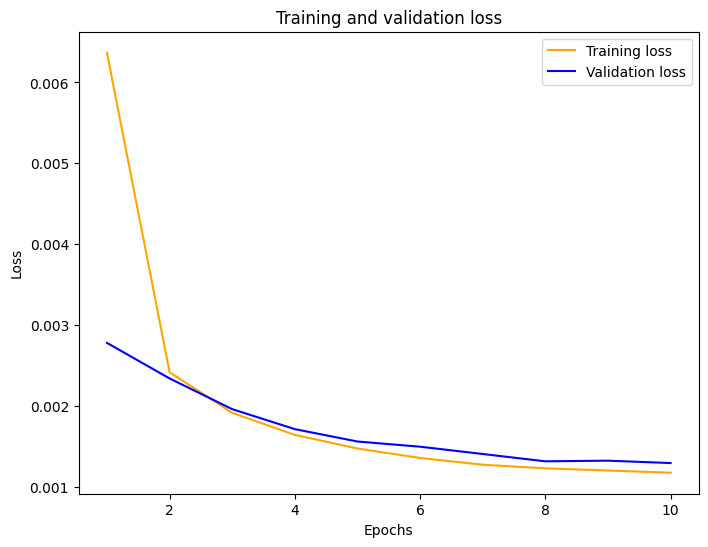

In [24]:
plot_curve(hist2)

In [25]:
train2.reset_index(inplace=True)
test2.reset_index(inplace=True)

In [26]:
test2

DateTime  cloud_cover      LSTM
0    2021-12-13 16:28:00        0.124  0.122187
1    2021-12-13 16:29:00        0.119  0.120392
2    2021-12-13 16:30:00        0.103  0.116082
3    2021-12-13 16:31:00        0.104  0.102356
4    2021-12-13 16:32:00        0.101  0.100649
...                  ...          ...       ...
1364 2021-12-16 13:58:00        0.168  0.164229
1365 2021-12-16 13:59:00        0.169  0.163935
1366 2021-12-16 14:00:00        0.147  0.164733
1367 2021-12-16 14:01:00        0.145  0.146669
1368 2021-12-16 14:02:00        0.144  0.141895

[1369 rows x 3 columns]

In [27]:
print('lstm_mse_error lag 15 : ', lstm_mse_error2)

lstm_mse_error lag 15 :  0.0012907112106940101


In [28]:
plot_test(train2,test2)

In [29]:
mse_lag15 = np.mean(mse2)
mse_lag15

0.0015657318144775786

---

## Run in loop and lags 20

### Optimizer adam first layer 50 batch size 32 learning rate 0.005 epochs 10 

In [30]:
cv3 = TimeSeriesSplit(n_splits=10)
mse3 = []
for train3,test3 in cv3.split(cloud_cover):
    print('TRAIN:', train3.shape, 'TEST:', test3.shape) 
    train3, test3 = cloud_cover.iloc[train3, :], cloud_cover.iloc[test3, :]
    train3 = train3.set_index('DateTime')
    test3 = test3.set_index('DateTime')
    
    # X_train3, y_train3, X_test3 and y_test3
    X_train3, y_train3, X_test3, y_test3, sc3 = Xtrain_ytrain(train3,test3,20)

    # model
    regressor3 = Sequential()
    regressor3.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train3.shape[1], 1)))
    regressor3.add(Dense(units = 1))
    opt = optimizers.Adam(learning_rate=0.005)
    regressor3.compile(optimizer = opt, loss = 'mean_squared_error')
    hist3 = regressor3.fit(X_train3, y_train3, validation_data=(X_test3, y_test3), epochs = 10, batch_size = 32) 
    predict_scaled3 = regressor3.predict(X_test3)
    predict3 = sc3.inverse_transform(predict_scaled3)
    test3['LSTM'] = predict3
    lstm_mse_error3 = mean_squared_error(test3['cloud_cover'], test3['LSTM'], squared=True)
    print('lstm mse error lags 20 : ', lstm_mse_error3)
    print('\n')
    mse3.append(lstm_mse_error3)

TRAIN: (1371,) TEST: (1369,)
X_train Shape : (1351, 20, 1)
y_train Shape : (1351, 1)
X_test Shape :  (1369, 20, 1)
y_test Shape :  (1369, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
43/43 [==============================] - 5s 28ms/step - loss: 0.0379 - val_loss: 0.0039
Epoch 2/10
43/43 [==============================] - 1s 14ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 3/10
43/43 [==============================] - 1s 13ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 4/10
43/43 [==============================] - 1s 13ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 5/10
43/43 [==============================] - 1s 13ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/10
43/43 [==============================] - 1s 14ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/10
43/43 [==============================] - 1s 13ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 8/10
43/43 [==============================] - 1s 14ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 9/10
43/43 [==============================] - 1s 15ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/10
43/43 [==============================] - 1s 3ms/step
lstm mse error lags 20 :  0.0020124294034078

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
85/85 [==============================] - 3s 16ms/step - loss: 0.0109 - val_loss: 0.0033
Epoch 2/10
85/85 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 3/10
85/85 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 4/10
85/85 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 5/10
85/85 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 6/10
85/85 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/10
85/85 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 8/10
85/85 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/10
85/85 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 10/10
43/43 [==============================] - 1s 4ms/step
lstm mse error lags 20 :  0.0013456652380716219


T

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
128/128 [==============================] - 4s 15ms/step - loss: 0.0154 - val_loss: 0.0026
Epoch 2/10
128/128 [==============================] - 1s 10ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 3/10
128/128 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 4/10
128/128 [==============================] - 1s 10ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 5/10
128/128 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 6/10
128/128 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/10
128/128 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/10
128/128 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 9/10
128/128 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 10/10
43/43 [==============================] - 1s 4ms/step
lstm mse error lags 20 :  

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
171/171 [==============================] - 5s 14ms/step - loss: 0.0109 - val_loss: 0.0020
Epoch 2/10
171/171 [==============================] - 2s 9ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 3/10
171/171 [==============================] - 2s 10ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 4/10
171/171 [==============================] - 2s 10ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 5/10
171/171 [==============================] - 2s 10ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/10
171/171 [==============================] - 2s 10ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 7/10
171/171 [==============================] - 2s 10ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 8/10
171/171 [==============================] - 2s 10ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/10
171/171 [==============================] - 2s 9ms/step - loss: 0.0012 - val_loss: 9.5874e-04
Epoch 10/10
43/43 [==============================] - 1s 3ms/step
lstm mse error lags 20 :

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
214/214 [==============================] - 5s 12ms/step - loss: 0.0076 - val_loss: 4.5656e-04
Epoch 2/10
214/214 [==============================] - 2s 9ms/step - loss: 0.0022 - val_loss: 8.7769e-04
Epoch 3/10
214/214 [==============================] - 2s 9ms/step - loss: 0.0018 - val_loss: 3.4069e-04
Epoch 4/10
214/214 [==============================] - 2s 11ms/step - loss: 0.0016 - val_loss: 3.0463e-04
Epoch 5/10
214/214 [==============================] - 3s 12ms/step - loss: 0.0014 - val_loss: 7.4227e-04
Epoch 6/10
214/214 [==============================] - 2s 11ms/step - loss: 0.0013 - val_loss: 1.5141e-04
Epoch 7/10
214/214 [==============================] - 3s 12ms/step - loss: 0.0012 - val_loss: 6.0124e-04
Epoch 8/10
214/214 [==============================] - 3s 12ms/step - loss: 0.0012 - val_loss: 5.9570e-04
Epoch 9/10
214/214 [==============================] - 2s 12ms/step - loss: 0.0012 - val_loss: 1.6211e-04
Epoch 10/10
43/43 [==============================] - 1s 5

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
257/257 [==============================] - 6s 13ms/step - loss: 0.0075 - val_loss: 0.0013
Epoch 2/10
257/257 [==============================] - 3s 11ms/step - loss: 0.0020 - val_loss: 9.7863e-04
Epoch 3/10
257/257 [==============================] - 3s 11ms/step - loss: 0.0016 - val_loss: 8.9025e-04
Epoch 4/10
257/257 [==============================] - 3s 11ms/step - loss: 0.0014 - val_loss: 6.4046e-04
Epoch 5/10
257/257 [==============================] - 3s 11ms/step - loss: 0.0012 - val_loss: 8.4852e-04
Epoch 6/10
257/257 [==============================] - 3s 11ms/step - loss: 0.0011 - val_loss: 5.4749e-04
Epoch 7/10
257/257 [==============================] - 3s 11ms/step - loss: 0.0010 - val_loss: 4.7368e-04
Epoch 8/10
257/257 [==============================] - 3s 11ms/step - loss: 0.0010 - val_loss: 5.9657e-04
Epoch 9/10
257/257 [==============================] - 3s 11ms/step - loss: 0.0010 - val_loss: 4.9837e-04
Epoch 10/10
43/43 [==============================] - 1s 4ms

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
299/299 [==============================] - 6s 12ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 2/10
299/299 [==============================] - 3s 11ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 3/10
299/299 [==============================] - 3s 11ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 4/10
299/299 [==============================] - 3s 11ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/10
299/299 [==============================] - 3s 11ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 6/10
299/299 [==============================] - 3s 10ms/step - loss: 9.8979e-04 - val_loss: 0.0012
Epoch 7/10
299/299 [==============================] - 3s 11ms/step - loss: 9.6751e-04 - val_loss: 0.0012
Epoch 8/10
299/299 [==============================] - 3s 11ms/step - loss: 9.3961e-04 - val_loss: 0.0012
Epoch 9/10
299/299 [==============================] - 3s 10ms/step - loss: 9.3972e-04 - val_loss: 0.0012
Epoch 10/10
43/43 [==============================] - 1s 4ms/step
lstm mse e

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
342/342 [==============================] - 7s 15ms/step - loss: 0.0055 - val_loss: 0.0022
Epoch 2/10
342/342 [==============================] - 4s 10ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3/10
342/342 [==============================] - 3s 10ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 4/10
342/342 [==============================] - 4s 11ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 5/10
342/342 [==============================] - 4s 13ms/step - loss: 9.9993e-04 - val_loss: 0.0015
Epoch 6/10
342/342 [==============================] - 4s 10ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 7/10
342/342 [==============================] - 4s 11ms/step - loss: 9.8750e-04 - val_loss: 0.0014
Epoch 8/10
342/342 [==============================] - 4s 10ms/step - loss: 9.8237e-04 - val_loss: 0.0014
Epoch 9/10
342/342 [==============================] - 4s 10ms/step - loss: 9.7646e-04 - val_loss: 0.0014
Epoch 10/10
43/43 [==============================] - 1s 4ms/step
lstm mse e

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
385/385 [==============================] - 8s 13ms/step - loss: 0.0049 - val_loss: 0.0032
Epoch 2/10
385/385 [==============================] - 4s 11ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 3/10
385/385 [==============================] - 4s 11ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 4/10
385/385 [==============================] - 4s 12ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 5/10
385/385 [==============================] - 4s 11ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 6/10
385/385 [==============================] - 4s 11ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 7/10
385/385 [==============================] - 4s 11ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 8/10
385/385 [==============================] - 4s 11ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 9/10
385/385 [==============================] - 4s 11ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 10/10
43/43 [==============================] - 1s 5ms/step
lstm mse error lags 20 :  

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
428/428 [==============================] - 8s 12ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch 2/10
428/428 [==============================] - 6s 13ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/10
428/428 [==============================] - 5s 12ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/10
428/428 [==============================] - 5s 11ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 5/10
428/428 [==============================] - 4s 10ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/10
428/428 [==============================] - 4s 10ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/10
428/428 [==============================] - 4s 10ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/10
428/428 [==============================] - 5s 11ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/10
428/428 [==============================] - 4s 10ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 10/10
43/43 [==============================] - 1s 4ms/step
lstm mse error lags 20 :  

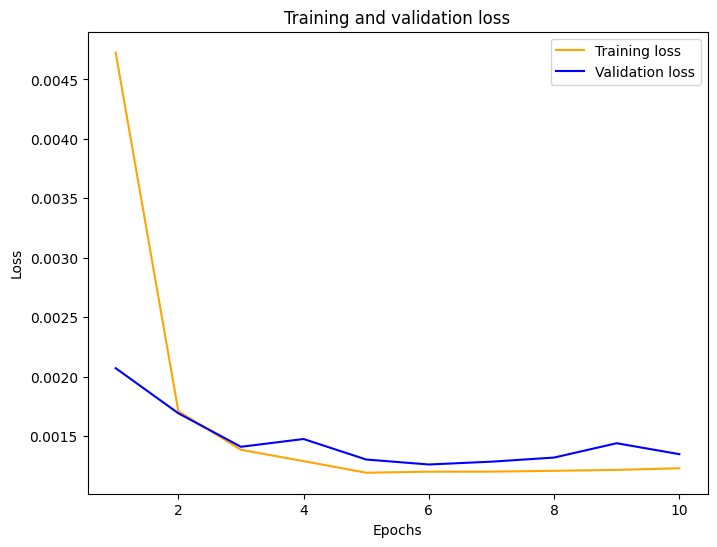

In [31]:
plot_curve(hist3)

In [32]:
train3.reset_index(inplace=True)
test3.reset_index(inplace=True)

In [33]:
test3

DateTime  cloud_cover      LSTM
0    2021-12-13 16:28:00        0.124  0.116945
1    2021-12-13 16:29:00        0.119  0.115062
2    2021-12-13 16:30:00        0.103  0.110508
3    2021-12-13 16:31:00        0.104  0.095989
4    2021-12-13 16:32:00        0.101  0.095565
...                  ...          ...       ...
1364 2021-12-16 13:58:00        0.168  0.158386
1365 2021-12-16 13:59:00        0.169  0.158261
1366 2021-12-16 14:00:00        0.147  0.159129
1367 2021-12-16 14:01:00        0.145  0.139472
1368 2021-12-16 14:02:00        0.144  0.136219

[1369 rows x 3 columns]

In [34]:
print('lstm_mse_error lags 20 : ', lstm_mse_error3)

lstm_mse_error lags 20 :  0.001339668883700214


In [35]:
plot_test(train3,test3)

In [36]:
mse_lag20 = np.mean(mse3)
mse_lag20

0.0013094538257883727

---

## Run in loop and lags 25

### Optimizer adam first layer 50 batch size 32 learning rate 0.005 epochs 10 

In [37]:
cv4 = TimeSeriesSplit(n_splits=10)
mse4 = []
for train4,test4 in cv4.split(cloud_cover):
    print('TRAIN:', train4.shape, 'TEST:', test4.shape) 
    train4, test4 = cloud_cover.iloc[train4, :], cloud_cover.iloc[test4, :]
    train4 = train4.set_index('DateTime')
    test4 = test4.set_index('DateTime')
    
    # X_train4, y_train4, X_test4 and y_test4
    X_train4, y_train4, X_test4, y_test4, sc4 = Xtrain_ytrain(train4,test4,25)

    # model
    regressor4 = Sequential()
    regressor4.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train4.shape[1], 1)))
    regressor4.add(Dense(units = 1))
    opt = optimizers.Adam(learning_rate=0.005)
    regressor4.compile(optimizer = opt, loss = 'mean_squared_error')
    hist4 = regressor4.fit(X_train4, y_train4, validation_data=(X_test4, y_test4), epochs = 10, batch_size = 32) 
    predict_scaled4 = regressor4.predict(X_test4)
    predict4 = sc4.inverse_transform(predict_scaled4)
    test4['LSTM'] = predict4
    lstm_mse_error4 = mean_squared_error(test4['cloud_cover'], test4['LSTM'], squared=True)
    print('lstm mse error lags 25 : ', lstm_mse_error4)
    print('\n')
    mse4.append(lstm_mse_error4)

TRAIN: (1371,) TEST: (1369,)
X_train Shape : (1346, 25, 1)
y_train Shape : (1346, 1)
X_test Shape :  (1369, 25, 1)
y_test Shape :  (1369, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
43/43 [==============================] - 4s 29ms/step - loss: 0.0374 - val_loss: 0.0041
Epoch 2/10
43/43 [==============================] - 1s 16ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 3/10
43/43 [==============================] - 1s 16ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 4/10
43/43 [==============================] - 1s 15ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 5/10
43/43 [==============================] - 1s 15ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 6/10
43/43 [==============================] - 1s 18ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 7/10
43/43 [==============================] - 1s 16ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/10
43/43 [==============================] - 1s 17ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 9/10
43/43 [==============================] - 1s 16ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/10
43/43 [==============================] - 1s 4ms/step
lstm mse error lags 25 :  0.0021794055431421

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
85/85 [==============================] - 4s 20ms/step - loss: 0.0117 - val_loss: 0.0040
Epoch 2/10
85/85 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 3/10
85/85 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 4/10
85/85 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 5/10
85/85 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 6/10
85/85 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 7/10
85/85 [==============================] - 1s 17ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 8/10
85/85 [==============================] - 1s 16ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 9/10
85/85 [==============================] - 1s 16ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 10/10
43/43 [==============================] - 1s 5ms/step
lstm mse error lags 25 :  0.0014738138752023

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
128/128 [==============================] - 6s 18ms/step - loss: 0.0180 - val_loss: 0.0022
Epoch 2/10
128/128 [==============================] - 2s 14ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 3/10
128/128 [==============================] - 2s 14ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 4/10
128/128 [==============================] - 2s 15ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 5/10
128/128 [==============================] - 2s 15ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/10
128/128 [==============================] - 2s 14ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/10
128/128 [==============================] - 2s 14ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 8/10
128/128 [==============================] - 2s 14ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/10
128/128 [==============================] - 2s 14ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/10
43/43 [==============================] - 1s 5ms/step
lstm mse error lags 25 :  

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
171/171 [==============================] - 5s 17ms/step - loss: 0.0064 - val_loss: 0.0019
Epoch 2/10
171/171 [==============================] - 2s 13ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 3/10
171/171 [==============================] - 2s 13ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 4/10
171/171 [==============================] - 2s 13ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 5/10
171/171 [==============================] - 2s 13ms/step - loss: 0.0014 - val_loss: 9.8530e-04
Epoch 6/10
171/171 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 7/10
171/171 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 9.6510e-04
Epoch 8/10
171/171 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 9.9633e-04
Epoch 9/10
171/171 [==============================] - 2s 13ms/step - loss: 0.0012 - val_loss: 9.7052e-04
Epoch 10/10
43/43 [==============================] - 1s 5ms/step
lstm mse e

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
214/214 [==============================] - 6s 15ms/step - loss: 0.0062 - val_loss: 6.7163e-04
Epoch 2/10
214/214 [==============================] - 3s 13ms/step - loss: 0.0021 - val_loss: 3.4957e-04
Epoch 3/10
214/214 [==============================] - 3s 13ms/step - loss: 0.0016 - val_loss: 5.2871e-04
Epoch 4/10
214/214 [==============================] - 3s 12ms/step - loss: 0.0014 - val_loss: 2.2527e-04
Epoch 5/10
214/214 [==============================] - 3s 13ms/step - loss: 0.0013 - val_loss: 7.7785e-04
Epoch 6/10
214/214 [==============================] - 3s 13ms/step - loss: 0.0012 - val_loss: 1.5523e-04
Epoch 7/10
214/214 [==============================] - 3s 13ms/step - loss: 0.0012 - val_loss: 3.2259e-04
Epoch 8/10
214/214 [==============================] - 3s 13ms/step - loss: 0.0012 - val_loss: 3.7843e-04
Epoch 9/10
214/214 [==============================] - 3s 13ms/step - loss: 0.0012 - val_loss: 3.1946e-04
Epoch 10/10
43/43 [==============================] - 1s

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
256/256 [==============================] - 6s 15ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 2/10
256/256 [==============================] - 3s 13ms/step - loss: 0.0019 - val_loss: 9.0282e-04
Epoch 3/10
256/256 [==============================] - 3s 13ms/step - loss: 0.0015 - val_loss: 7.1588e-04
Epoch 4/10
256/256 [==============================] - 3s 14ms/step - loss: 0.0013 - val_loss: 5.9423e-04
Epoch 5/10
256/256 [==============================] - 3s 13ms/step - loss: 0.0012 - val_loss: 5.8352e-04
Epoch 6/10
256/256 [==============================] - 3s 13ms/step - loss: 0.0011 - val_loss: 5.8580e-04
Epoch 7/10
256/256 [==============================] - 3s 13ms/step - loss: 0.0010 - val_loss: 4.8632e-04
Epoch 8/10
256/256 [==============================] - 3s 13ms/step - loss: 0.0010 - val_loss: 4.8004e-04
Epoch 9/10
256/256 [==============================] - 3s 13ms/step - loss: 0.0010 - val_loss: 6.5750e-04
Epoch 10/10
43/43 [==============================] - 1s 5ms

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
299/299 [==============================] - 7s 14ms/step - loss: 0.0069 - val_loss: 0.0027
Epoch 2/10
299/299 [==============================] - 4s 13ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 3/10
299/299 [==============================] - 4s 12ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 4/10
299/299 [==============================] - 4s 13ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/10
299/299 [==============================] - 4s 13ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 6/10
299/299 [==============================] - 4s 13ms/step - loss: 9.8353e-04 - val_loss: 0.0013
Epoch 7/10
299/299 [==============================] - 4s 13ms/step - loss: 9.7420e-04 - val_loss: 0.0013
Epoch 8/10
299/299 [==============================] - 4s 13ms/step - loss: 9.4901e-04 - val_loss: 0.0013
Epoch 9/10
299/299 [==============================] - 4s 12ms/step - loss: 9.4214e-04 - val_loss: 0.0012
Epoch 10/10
43/43 [==============================] - 1s 6ms/step
lstm mse e

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
342/342 [==============================] - 10s 15ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 2/10
342/342 [==============================] - 4s 12ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3/10
342/342 [==============================] - 4s 12ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 4/10
342/342 [==============================] - 4s 12ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 5/10
342/342 [==============================] - 4s 12ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 6/10
342/342 [==============================] - 4s 12ms/step - loss: 9.8167e-04 - val_loss: 0.0014
Epoch 7/10
342/342 [==============================] - 4s 12ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 8/10
342/342 [==============================] - 4s 12ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 9/10
342/342 [==============================] - 4s 12ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 10/10
43/43 [==============================] - 1s 5ms/step
lstm mse error lags 2

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
385/385 [==============================] - 7s 13ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 2/10
385/385 [==============================] - 4s 12ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 3/10
385/385 [==============================] - 5s 12ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 4/10
385/385 [==============================] - 5s 12ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 5/10
385/385 [==============================] - 5s 12ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 6/10
385/385 [==============================] - 5s 12ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 7/10
385/385 [==============================] - 5s 12ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 8/10
385/385 [==============================] - 5s 12ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 9/10
385/385 [==============================] - 5s 12ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 10/10
43/43 [==============================] - 1s 5ms/step
lstm mse error lags 25 :  

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
428/428 [==============================] - 8s 13ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 2/10
428/428 [==============================] - 5s 12ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/10
428/428 [==============================] - 5s 12ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 4/10
428/428 [==============================] - 5s 12ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/10
428/428 [==============================] - 5s 12ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 6/10
428/428 [==============================] - 5s 12ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/10
428/428 [==============================] - 5s 12ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 8/10
428/428 [==============================] - 5s 12ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/10
428/428 [==============================] - 5s 12ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/10
43/43 [==============================] - 1s 5ms/step
lstm mse error lags 25 :  

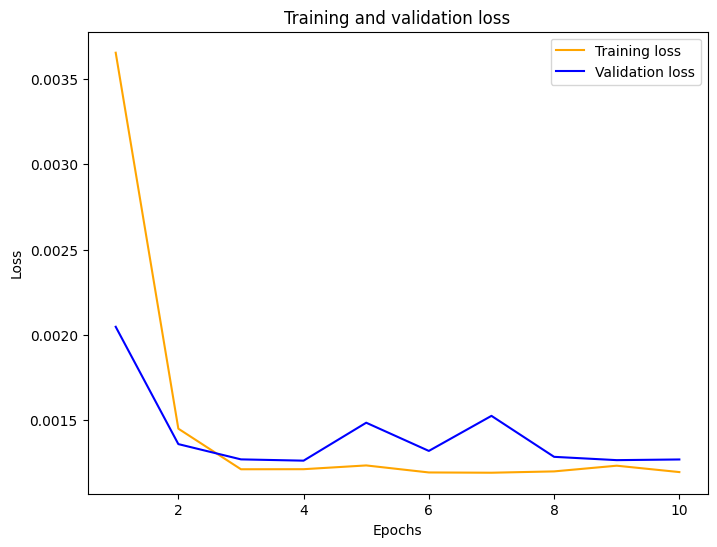

In [38]:
plot_curve(hist4)

In [39]:
train4.reset_index(inplace=True)
test4.reset_index(inplace=True)

In [40]:
test4

DateTime  cloud_cover      LSTM
0    2021-12-13 16:28:00        0.124  0.123512
1    2021-12-13 16:29:00        0.119  0.121456
2    2021-12-13 16:30:00        0.103  0.116670
3    2021-12-13 16:31:00        0.104  0.101658
4    2021-12-13 16:32:00        0.101  0.101080
...                  ...          ...       ...
1364 2021-12-16 13:58:00        0.168  0.165112
1365 2021-12-16 13:59:00        0.169  0.164984
1366 2021-12-16 14:00:00        0.147  0.165911
1367 2021-12-16 14:01:00        0.145  0.145617
1368 2021-12-16 14:02:00        0.144  0.142089

[1369 rows x 3 columns]

In [41]:
print('lstm_mse_error lags 25 : ', lstm_mse_error4)

lstm_mse_error lags 25 :  0.0012645238452059073


In [42]:
plot_test(train4,test4)

In [43]:
mse_lag25 = np.mean(mse4)
mse_lag25

0.0013293048641889028

---

## Run in loop and lags 30

### Optimizer RMSprop batch size 32 first layer 50 second layer 50 

In [45]:
cv5 = TimeSeriesSplit(n_splits=10)
mse5 = []
for train5,test5 in cv5.split(cloud_cover):
    print('TRAIN:', train5.shape, 'TEST:', test5.shape) 
    train5, test5 = cloud_cover.iloc[train5, :], cloud_cover.iloc[test5, :]
    train5 = train5.set_index('DateTime')
    test5 = test5.set_index('DateTime')
    
    # X_train5, y_train5, X_test5 and y_test5
    X_train5, y_train5, X_test5, y_test5, sc5 = Xtrain_ytrain(train5,test5,30)

    # model
    regressor5 = Sequential()
    regressor5.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train5.shape[1], 1)))
    regressor5.add(LSTM(units = 50))
    regressor5.add(Dense(units = 1))
    regressor5.compile(optimizer = 'RMSprop', loss = 'mean_squared_error')
    hist5 = regressor5.fit(X_train5, y_train5, validation_data=(X_test5, y_test5), epochs = 10, batch_size = 32) 
    predict_scaled5 = regressor5.predict(X_test5)
    predict5 = sc5.inverse_transform(predict_scaled5)
    test5['LSTM'] = predict5
    lstm_mse_error5 = mean_squared_error(test5['cloud_cover'], test5['LSTM'], squared=True)
    print('lstm mse error lags 30 : ', lstm_mse_error5)
    print('\n')
    mse5.append(lstm_mse_error5)

TRAIN: (1371,) TEST: (1369,)
X_train Shape : (1341, 30, 1)
y_train Shape : (1341, 1)
X_test Shape :  (1369, 30, 1)
y_test Shape :  (1369, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
42/42 [==============================] - 10s 74ms/step - loss: 0.0263 - val_loss: 0.0142
Epoch 2/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0106 - val_loss: 0.0069
Epoch 3/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0080 - val_loss: 0.0065
Epoch 4/10
42/42 [==============================] - 2s 40ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 5/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 6/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0049 - val_loss: 0.0065
Epoch 7/10
42/42 [==============================] - 2s 41ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 8/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 9/10
42/42 [==============================] - 2s 39ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 10/10
43/43 [==============================] - 2s 15ms/step
lstm mse error lags 30 :  0.00282800140570

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
85/85 [==============================] - 9s 48ms/step - loss: 0.0202 - val_loss: 0.0097
Epoch 2/10
85/85 [==============================] - 3s 34ms/step - loss: 0.0067 - val_loss: 0.0051
Epoch 3/10
85/85 [==============================] - 3s 30ms/step - loss: 0.0051 - val_loss: 0.0039
Epoch 4/10
85/85 [==============================] - 3s 31ms/step - loss: 0.0039 - val_loss: 0.0125
Epoch 5/10
85/85 [==============================] - 2s 29ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 6/10
85/85 [==============================] - 3s 30ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 7/10
85/85 [==============================] - 2s 29ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 8/10
85/85 [==============================] - 3s 33ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 9/10
85/85 [==============================] - 3s 35ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 10/10
43/43 [==============================] - 3s 22ms/step
lstm mse error lags 30 :  0.001723268124977

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
128/128 [==============================] - 14s 46ms/step - loss: 0.0164 - val_loss: 0.0033
Epoch 2/10
128/128 [==============================] - 5s 38ms/step - loss: 0.0060 - val_loss: 0.0069
Epoch 3/10
128/128 [==============================] - 5s 42ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 4/10
128/128 [==============================] - 11s 84ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 5/10
128/128 [==============================] - 7s 52ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 6/10
128/128 [==============================] - 9s 67ms/step - loss: 0.0021 - val_loss: 0.0038
Epoch 7/10
128/128 [==============================] - 8s 62ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/10
128/128 [==============================] - 6s 44ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 9/10
128/128 [==============================] - 6s 46ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 10/10
43/43 [==============================] - 3s 17ms/step
lstm mse error lags 30 

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
171/171 [==============================] - 18s 53ms/step - loss: 0.0142 - val_loss: 0.0026
Epoch 2/10
171/171 [==============================] - 7s 42ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 3/10
171/171 [==============================] - 8s 49ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 4/10
171/171 [==============================] - 8s 47ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 5/10
171/171 [==============================] - 9s 52ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 6/10
171/171 [==============================] - 8s 47ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 7/10
171/171 [==============================] - 8s 48ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 8/10
171/171 [==============================] - 8s 47ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 9/10
171/171 [==============================] - 9s 50ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 10/10
43/43 [==============================] - 3s 18ms/step
lstm mse error lags 30 :

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
214/214 [==============================] - 19s 54ms/step - loss: 0.0098 - val_loss: 0.0054
Epoch 2/10
214/214 [==============================] - 9s 43ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 3/10
214/214 [==============================] - 10s 46ms/step - loss: 0.0025 - val_loss: 0.0136
Epoch 4/10
214/214 [==============================] - 10s 45ms/step - loss: 0.0021 - val_loss: 0.0098
Epoch 5/10
214/214 [==============================] - 11s 50ms/step - loss: 0.0017 - val_loss: 0.0106
Epoch 6/10
214/214 [==============================] - 11s 50ms/step - loss: 0.0017 - val_loss: 0.0210
Epoch 7/10
214/214 [==============================] - 10s 45ms/step - loss: 0.0016 - val_loss: 2.0875e-04
Epoch 8/10
214/214 [==============================] - 10s 46ms/step - loss: 0.0015 - val_loss: 6.4667e-04
Epoch 9/10
214/214 [==============================] - 10s 47ms/step - loss: 0.0015 - val_loss: 0.0096
Epoch 10/10
43/43 [==============================] - 2s 17ms/step
lstm mse 

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
256/256 [==============================] - 20s 50ms/step - loss: 0.0095 - val_loss: 0.0047
Epoch 2/10
256/256 [==============================] - 11s 45ms/step - loss: 0.0036 - val_loss: 9.8399e-04
Epoch 3/10
256/256 [==============================] - 11s 43ms/step - loss: 0.0025 - val_loss: 8.5637e-04
Epoch 4/10
256/256 [==============================] - 11s 44ms/step - loss: 0.0020 - val_loss: 7.2053e-04
Epoch 5/10
256/256 [==============================] - 12s 46ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/10
256/256 [==============================] - 11s 45ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 7/10
256/256 [==============================] - 12s 46ms/step - loss: 0.0014 - val_loss: 5.4527e-04
Epoch 8/10
256/256 [==============================] - 12s 45ms/step - loss: 0.0014 - val_loss: 4.9573e-04
Epoch 9/10
256/256 [==============================] - 12s 45ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 10/10
43/43 [==============================] - 2s 17ms/s

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
299/299 [==============================] - 23s 48ms/step - loss: 0.0095 - val_loss: 0.0035
Epoch 2/10
299/299 [==============================] - 13s 43ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 3/10
299/299 [==============================] - 15s 49ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 4/10
299/299 [==============================] - 13s 44ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 5/10
299/299 [==============================] - 13s 45ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/10
299/299 [==============================] - 14s 46ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/10
299/299 [==============================] - 14s 46ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/10
299/299 [==============================] - 14s 48ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/10
299/299 [==============================] - 14s 46ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/10
43/43 [==============================] - 2s 17ms/step
lstm mse error l

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
342/342 [==============================] - 25s 49ms/step - loss: 0.0085 - val_loss: 0.0031
Epoch 2/10
342/342 [==============================] - 15s 43ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 3/10
342/342 [==============================] - 15s 44ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 4/10
342/342 [==============================] - 15s 45ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/10
342/342 [==============================] - 15s 45ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/10
342/342 [==============================] - 16s 46ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/10
342/342 [==============================] - 15s 45ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 8/10
342/342 [==============================] - 15s 45ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 9/10
342/342 [==============================] - 16s 46ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/10
43/43 [==============================] - 2s 17ms/step
lstm mse error l

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
385/385 [==============================] - 24s 45ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 2/10
385/385 [==============================] - 17s 44ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 3/10
385/385 [==============================] - 17s 45ms/step - loss: 0.0017 - val_loss: 0.0070
Epoch 4/10
385/385 [==============================] - 17s 45ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 5/10
385/385 [==============================] - 17s 45ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 6/10
385/385 [==============================] - 17s 45ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 7/10
385/385 [==============================] - 18s 47ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 8/10
385/385 [==============================] - 21s 54ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 9/10
385/385 [==============================] - 17s 45ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 10/10
43/43 [==============================] - 3s 20ms/step
lstm mse error l

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/10
427/427 [==============================] - 28s 46ms/step - loss: 0.0061 - val_loss: 0.0024
Epoch 2/10
427/427 [==============================] - 19s 43ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 3/10
427/427 [==============================] - 24s 57ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 4/10
427/427 [==============================] - 21s 49ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 5/10
427/427 [==============================] - 18s 43ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 6/10
427/427 [==============================] - 18s 43ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 7/10
427/427 [==============================] - 18s 43ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/10
427/427 [==============================] - 18s 43ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/10
427/427 [==============================] - 19s 44ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/10
43/43 [==============================] - 3s 18ms/step
lstm mse error l

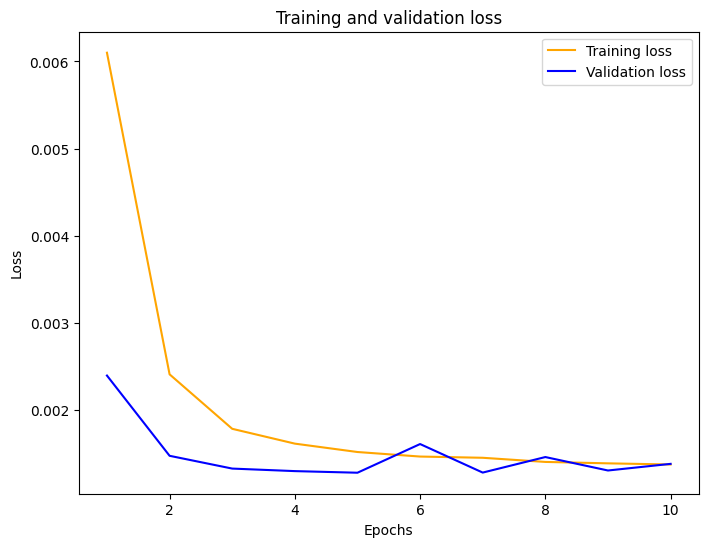

In [46]:
plot_curve(hist5)

In [47]:
train5.reset_index(inplace=True)
test5.reset_index(inplace=True)

In [48]:
test5

DateTime  cloud_cover      LSTM
0    2021-12-13 16:28:00        0.124  0.134384
1    2021-12-13 16:29:00        0.119  0.131745
2    2021-12-13 16:30:00        0.103  0.126696
3    2021-12-13 16:31:00        0.104  0.111565
4    2021-12-13 16:32:00        0.101  0.110025
...                  ...          ...       ...
1364 2021-12-16 13:58:00        0.168  0.175126
1365 2021-12-16 13:59:00        0.169  0.174905
1366 2021-12-16 14:00:00        0.147  0.175825
1367 2021-12-16 14:01:00        0.145  0.156095
1368 2021-12-16 14:02:00        0.144  0.151014

[1369 rows x 3 columns]

In [49]:
print('lstm_mse_error lags 30 : ', lstm_mse_error5)

lstm_mse_error lags 30 :  0.0013693574508383015


In [50]:
plot_test(train5,test5)

In [51]:
mse_lag30 = np.mean(mse5)
mse_lag30

0.001936258614067846

---

In [59]:
regressor.save('model_lag5_cv10.h5')
regressor1.save('model_lag10_cv10.h5')
regressor2.save('model_lag15_cv10.h5')
regressor3.save('model_lag20_cv10.h5')
regressor4.save('model_lag25_cv10.h5')
regressor5.save('model_lag30_cv10.h5')